In [1]:
import os
import json
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.utils import resample
from uuid import uuid4
from tqdm import tqdm
from typing import Dict, List, Optional
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import seaborn as sns

In [2]:
def load_json(json_file_path):
    print(f"Loading JSON file from {json_file_path}")
    with open(json_file_path, 'r') as f:
        return json.load(f)

In [3]:
def calculate_metrics(predictions_df, save_confusion_matrix=True, output_dir="../data"):
    """
    Calculate precision, accuracy, recall, F1-score, and confusion matrix.
    
    Args:
        predictions_df: DataFrame with 'true_species' and 'predicted_species' columns
        save_confusion_matrix: Whether to save confusion matrix plot
        output_dir: Directory to save confusion matrix plot
    
    Returns:
        Dictionary with all metrics
    """
    # Remove rows with failed predictions
    df_valid = predictions_df[predictions_df['predicted_species'].notna()].copy()
    
    if len(df_valid) == 0:
        print("❌ No valid predictions found!")
        return None
    
    y_true = df_valid['true_species']
    y_pred = df_valid['predicted_species']
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # Calculate per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    # Get unique classes
    classes = sorted(y_true.unique())
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    # Print results
    print("=" * 60)
    print("OVERALL METRICS")
    print("=" * 60)
    print(f"Accuracy:  {accuracy:.4f} ({accuracy:.2%})")
    print(f"Precision: {precision:.4f} ({precision:.2%})")
    print(f"Recall:    {recall:.4f} ({recall:.2%})")
    print(f"F1-Score:  {f1:.4f} ({f1:.2%})")
    print(f"\nTotal samples: {len(df_valid)}")
    print(f"Failed predictions: {len(predictions_df) - len(df_valid)}")
    
    print("\n" + "=" * 60)
    print("PER-CLASS METRICS")
    print("=" * 60)
    
    # Create per-class metrics DataFrame
    per_class_metrics = pd.DataFrame({
        'Species': classes,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class,
        'Support': [sum(y_true == c) for c in classes]
    })
    print(per_class_metrics.to_string(index=False))
    
    # Plot confusion matrix
    if save_confusion_matrix:
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=classes, yticklabels=classes,
                    cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix', fontsize=16, pad=20)
        plt.xlabel('Predicted Species', fontsize=12)
        plt.ylabel('True Species', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        
        # Save plot
        cm_path = os.path.join(output_dir, 'confusion_matrix.png')
        plt.savefig(cm_path, dpi=300, bbox_inches='tight')
        print(f"\n✓ Confusion matrix saved to: {cm_path}")
        plt.show()
    
    # Return metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'per_class_metrics': per_class_metrics,
        'classes': classes,
        'n_samples': len(df_valid),
        'n_failed': len(predictions_df) - len(df_valid)
    }
    
    return metrics

Load Predictions and Calculate Metrics

In [4]:
# Load predictions from CSV
predictions_df = pd.read_csv("../results/structured_predictions.csv")

# Display first few rows
print("Predictions DataFrame:")
predictions_df.head()

Predictions DataFrame:


,image_path,image_id,true_species,predicted_species,confidence,vote_counts,correct
0,data/serengeti/images/S4_T12_R2_IMAG1234.JPG,S4/T12/T12_R2/S4_T12_R2_IMAG1234,zebra,zebra,1.0,{'zebra': 5},True
1,data/serengeti/images/S6_B07_R2_IMAG0070.JPG,S6/B07/B07_R2/S6_B07_R2_IMAG0070,zebra,zebra,1.0,{'zebra': 5},True
2,data/serengeti/images/S4_C13_R1_IMAG1852.JPG,S4/C13/C13_R1/S4_C13_R1_IMAG1852,zebra,buffalo,1.0,{'buffalo': 5},False
3,data/serengeti/images/S2_C04_R3_IMAG1412.JPG,S2/C04/C04_R3/S2_C04_R3_IMAG1412,zebra,zebra,1.0,{'zebra': 5},True
4,data/serengeti/images/S2_G01_R1_PICT0873.JPG,S2/G01/G01_R1/S2_G01_R1_PICT0873,zebra,zebra,0.8,"{'zebra': 4, 'hippopotamus': 1}",True


OVERALL METRICS
Accuracy:  0.4908 (49.08%)
Precision: 0.5378 (53.78%)
Recall:    0.4908 (49.08%)
F1-Score:  0.4708 (47.08%)

Total samples: 1200
Failed predictions: 0

PER-CLASS METRICS
     Species  Precision  Recall  F1-Score  Support
      baboon   0.372727    0.41  0.390476      100
     buffalo   0.514563    0.53  0.522167      100
     cheetah   0.868852    0.53  0.658385      100
    elephant   0.735294    0.75  0.742574      100
     giraffe   0.949367    0.75  0.837989      100
  guineafowl   0.942308    0.49  0.644737      100
hippopotamus   0.231544    0.69  0.346734      100
hyenaspotted   0.353846    0.46  0.400000      100
      impala   0.000000    0.00  0.000000      100
     ostrich   0.727273    0.40  0.516129      100
     warthog   0.333333    0.01  0.019417      100
       zebra   0.424390    0.87  0.570492      100



✓ Confusion matrix saved to: ../data/confusion_matrix.png


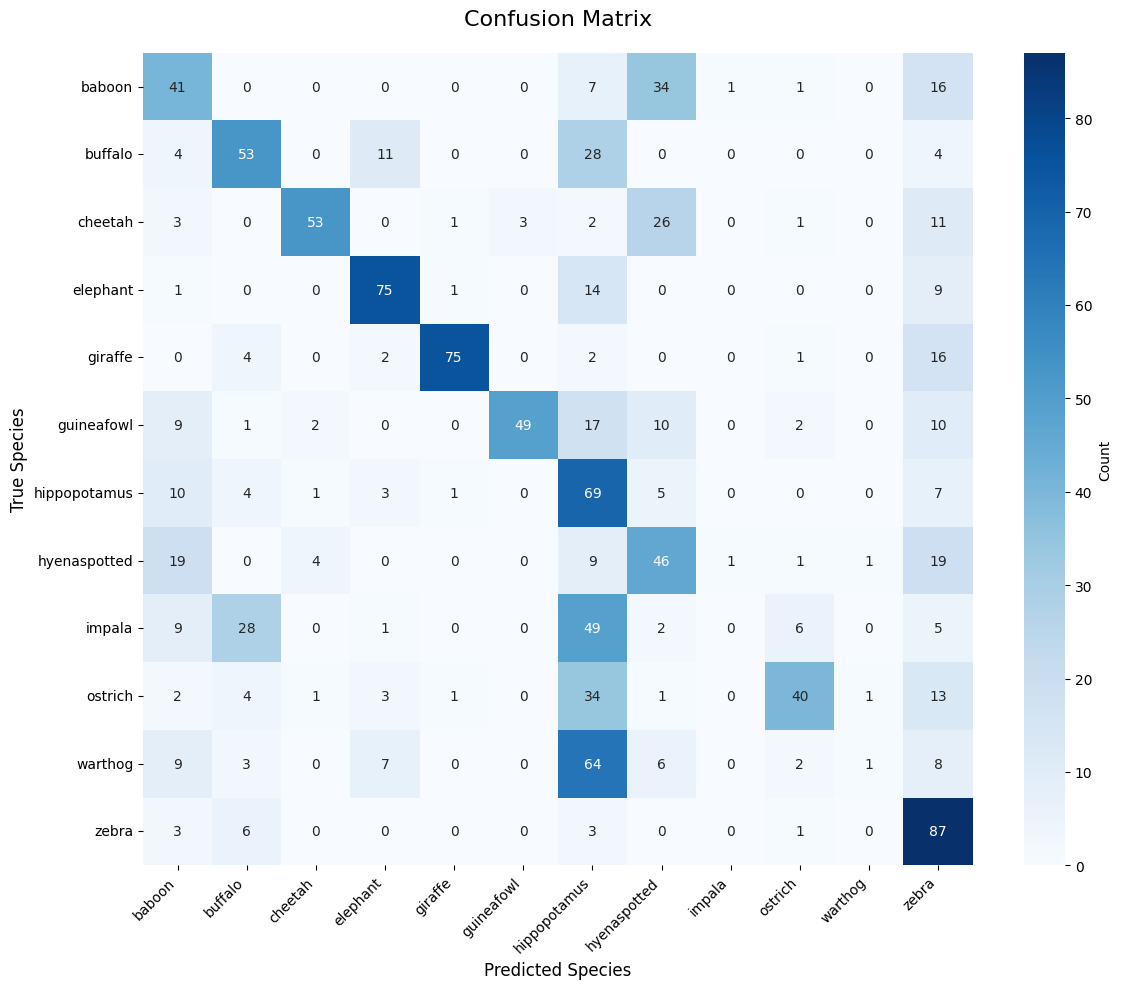

In [5]:
# Calculate all metrics
metrics = calculate_metrics(
    predictions_df=predictions_df,
    save_confusion_matrix=True,
    output_dir="../data"
)

In [6]:
# Display per-class metrics
print("\nDetailed Per-Class Metrics:")
metrics['per_class_metrics']


Detailed Per-Class Metrics:


,Species,Precision,Recall,F1-Score,Support
0,baboon,0.372727,0.41,0.390476,100
1,buffalo,0.514563,0.53,0.522167,100
2,cheetah,0.868852,0.53,0.658385,100
3,elephant,0.735294,0.75,0.742574,100
4,giraffe,0.949367,0.75,0.837989,100
5,guineafowl,0.942308,0.49,0.644737,100
6,hippopotamus,0.231544,0.69,0.346734,100
7,hyenaspotted,0.353846,0.46,0.400000,100
8,impala,0.000000,0.00,0.000000,100
9,ostrich,0.727273,0.40,0.516129,100


In [7]:
# Save metrics summary to file
metrics_summary = {
    'accuracy': float(metrics['accuracy']),
    'precision': float(metrics['precision']),
    'recall': float(metrics['recall']),
    'f1_score': float(metrics['f1_score']),
    'n_samples': int(metrics['n_samples']),
    'n_failed': int(metrics['n_failed']),
    'per_class_metrics': metrics['per_class_metrics'].to_dict(orient='records')
}

with open('../results/metrics_summary(vStructured).json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)

In [8]:
def plot_accuracy_vs_confidence(predictions_df, output_dir="../results"):
    """
    Create visualizations showing the relationship between confidence and accuracy.
    
    Args:
        predictions_df: DataFrame with 'confidence' and 'correct' columns
        output_dir: Directory to save the plots
    
    Returns:
        Dictionary with accuracy statistics by confidence range
    """
    # ========================================================================
    # DATA PREPARATION
    # ========================================================================
    
    # Remove rows with failed predictions (where model returned None)
    df_valid = predictions_df[predictions_df['predicted_species'].notna()].copy()
    
    if len(df_valid) == 0:
        print("❌ No valid predictions found!")
        return None
    
    # Create confidence bins to group predictions by confidence level
    # Bins: [0.0-0.2], (0.2-0.4], (0.4-0.6], (0.6-0.8], (0.8-1.0]
    confidence_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    df_valid['confidence_bin'] = pd.cut(df_valid['confidence'], 
                                         bins=confidence_bins, 
                                         include_lowest=True)
    
    # Calculate accuracy metrics for each confidence bin
    # For each bin, we get: mean accuracy, number of correct predictions, total predictions
    accuracy_by_confidence = df_valid.groupby('confidence_bin', observed=True).agg({
        'correct': ['mean', 'sum', 'count']
    }).round(4)
    
    accuracy_by_confidence.columns = ['Accuracy', 'Correct', 'Total']
    accuracy_by_confidence['Accuracy_Pct'] = (accuracy_by_confidence['Accuracy'] * 100).round(2)
    
    # Print accuracy statistics table
    print("=" * 70)
    print("ACCURACY BY CONFIDENCE RANGE")
    print("=" * 70)
    print(accuracy_by_confidence)
    print("\n")
    
    # Create figure with 2x2 grid of subplots (4 charts total)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # ========================================================================
    # CHART 1 (Top Left): Accuracy by Confidence Range - Bar Chart
    # ========================================================================
    # Purpose: Shows how prediction accuracy varies across different confidence levels
    # Key insight: Higher confidence should ideally correspond to higher accuracy
    # Color coding: Red (low accuracy) → Yellow → Green (high accuracy)
    
    ax1 = axes[0, 0]
    bin_labels = [f'{b.left:.1f}-{b.right:.1f}' for b in accuracy_by_confidence.index]
    colors = plt.cm.RdYlGn(accuracy_by_confidence['Accuracy'])  # Color-code bars by accuracy
    
    bars = ax1.bar(range(len(accuracy_by_confidence)), 
                    accuracy_by_confidence['Accuracy_Pct'],
                    color=colors, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Confidence Range', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Accuracy by Confidence Range', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xticks(range(len(accuracy_by_confidence)))
    ax1.set_xticklabels(bin_labels, rotation=0)
    ax1.set_ylim(0, 105)  # Set y-axis limit to 105% for label space
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add percentage labels on top of each bar for easy reading
    for i, (bar, val) in enumerate(zip(bars, accuracy_by_confidence['Accuracy_Pct'])):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{val:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # ========================================================================
    # CHART 2 (Top Right): Sample Distribution by Confidence - Bar Chart
    # ========================================================================
    # Purpose: Shows how many predictions fall into each confidence range
    # Key insight: Helps identify if the model is well-calibrated (balanced distribution)
    #             or if it's over/under-confident (skewed toward high/low confidence)
    
    ax2 = axes[0, 1]
    ax2.bar(range(len(accuracy_by_confidence)), 
            accuracy_by_confidence['Total'],
            color='steelblue', edgecolor='black', linewidth=1.5, alpha=0.7)
    ax2.set_xlabel('Confidence Range', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
    ax2.set_title('Sample Distribution by Confidence Range', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xticks(range(len(accuracy_by_confidence)))
    ax2.set_xticklabels(bin_labels, rotation=0)
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add count labels on top of each bar
    for i, val in enumerate(accuracy_by_confidence['Total']):
        ax2.text(i, val + 1, f'{int(val)}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # ========================================================================
    # CHART 3 (Bottom Left): Confidence vs Accuracy - Line Chart
    # ========================================================================
    # Purpose: Shows the relationship between confidence values and accuracy as a smooth trend line
    # Key insight: Visualizes calibration - how well the model's confidence aligns with actual accuracy
    #             A well-calibrated model shows increasing accuracy with increasing confidence
    #             The line should ideally trend upward from left to right
    
    ax3 = axes[1, 0]
    
    # Create finer confidence bins for smoother line (20 bins instead of 5)
    confidence_bins_fine = np.linspace(0, 1, 21)  # Creates 20 bins from 0 to 1
    df_valid['confidence_bin_fine'] = pd.cut(df_valid['confidence'], 
                                               bins=confidence_bins_fine, 
                                               include_lowest=True)
    
    # Calculate accuracy for each fine bin
    accuracy_fine = df_valid.groupby('confidence_bin_fine', observed=True).agg({
        'correct': 'mean'
    })
    
    # Get midpoints of bins for x-axis (represents confidence value)
    bin_midpoints = [interval.mid for interval in accuracy_fine.index]
    accuracy_values = accuracy_fine['correct'].values * 100  # Convert to percentage
    
    # Plot the confidence vs accuracy line
    ax3.plot(bin_midpoints, accuracy_values, 
             linewidth=3, color='darkblue', marker='o', markersize=6, 
             label='Accuracy Trend', alpha=0.8)
    
    # Add a diagonal reference line (perfect calibration: confidence = accuracy)
    ax3.plot([0, 1], [0, 100], 
             linestyle='--', color='gray', linewidth=2, alpha=0.5,
             label='Perfect Calibration')
    
    # Shade the area under the curve for visual emphasis
    ax3.fill_between(bin_midpoints, 0, accuracy_values, alpha=0.2, color='darkblue')
    
    ax3.set_xlabel('Confidence Value', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Confidence vs Accuracy Trend', fontsize=14, fontweight='bold', pad=15)
    ax3.legend(loc='upper left', framealpha=0.9)
    ax3.grid(alpha=0.3, linestyle='--')
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 105)
    
    # ========================================================================
    # CHART 4 (Bottom Right): Cumulative Accuracy Curve
    # ========================================================================
    # Purpose: Shows how accuracy changes as we include more predictions, sorted by confidence
    # Key insight: If the model is well-calibrated, the curve should start high (high-confidence
    #             predictions are accurate) and gradually decrease or stabilize as lower-confidence
    #             predictions are added. The red dashed line shows overall average accuracy.
    
    ax4 = axes[1, 1]
    # Sort predictions from highest to lowest confidence
    df_sorted = df_valid.sort_values('confidence', ascending=False).reset_index(drop=True)
    # Calculate cumulative accuracy: accuracy when including top N predictions
    df_sorted['cumulative_accuracy'] = df_sorted['correct'].expanding().mean() * 100
    df_sorted['sample_number'] = range(1, len(df_sorted) + 1)
    
    # Plot the cumulative accuracy curve
    ax4.plot(df_sorted['sample_number'], df_sorted['cumulative_accuracy'], 
             linewidth=2.5, color='purple', label='Cumulative Accuracy')
    
    # Add horizontal line showing overall average accuracy for comparison
    ax4.axhline(y=accuracy_by_confidence['Accuracy_Pct'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Overall Average')
    
    ax4.set_xlabel('Number of Predictions (sorted by confidence)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Cumulative Accuracy (%)', fontsize=12, fontweight='bold')
    ax4.set_title('Cumulative Accuracy (High to Low Confidence)', fontsize=14, fontweight='bold', pad=15)
    ax4.legend(loc='best', framealpha=0.9)
    ax4.grid(alpha=0.3, linestyle='--')
    ax4.set_ylim(0, 105)
    
    plt.tight_layout()
    
    # Save the complete 4-panel plot to file
    plot_path = os.path.join(output_dir, 'accuracy_vs_confidence.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: {plot_path}")
    plt.show()
    
    # Return summary statistics for further analysis
    stats = {
        'accuracy_by_bin': accuracy_by_confidence.to_dict(),
        'overall_accuracy': df_valid['correct'].mean(),
        'high_confidence_accuracy': df_valid[df_valid['confidence'] >= 0.8]['correct'].mean(),
        'low_confidence_accuracy': df_valid[df_valid['confidence'] < 0.6]['correct'].mean(),
    }
    
    return stats

ACCURACY BY CONFIDENCE RANGE
                Accuracy  Correct  Total  Accuracy_Pct
confidence_bin                                        
(0.2, 0.4]        0.2000        7     35         20.00
(0.4, 0.6]        0.2500       38    152         25.00
(0.6, 0.8]        0.3980       78    196         39.80
(0.8, 1.0]        0.5704      466    817         57.04




✓ Plot saved to: ../results/accuracy_vs_confidence.png


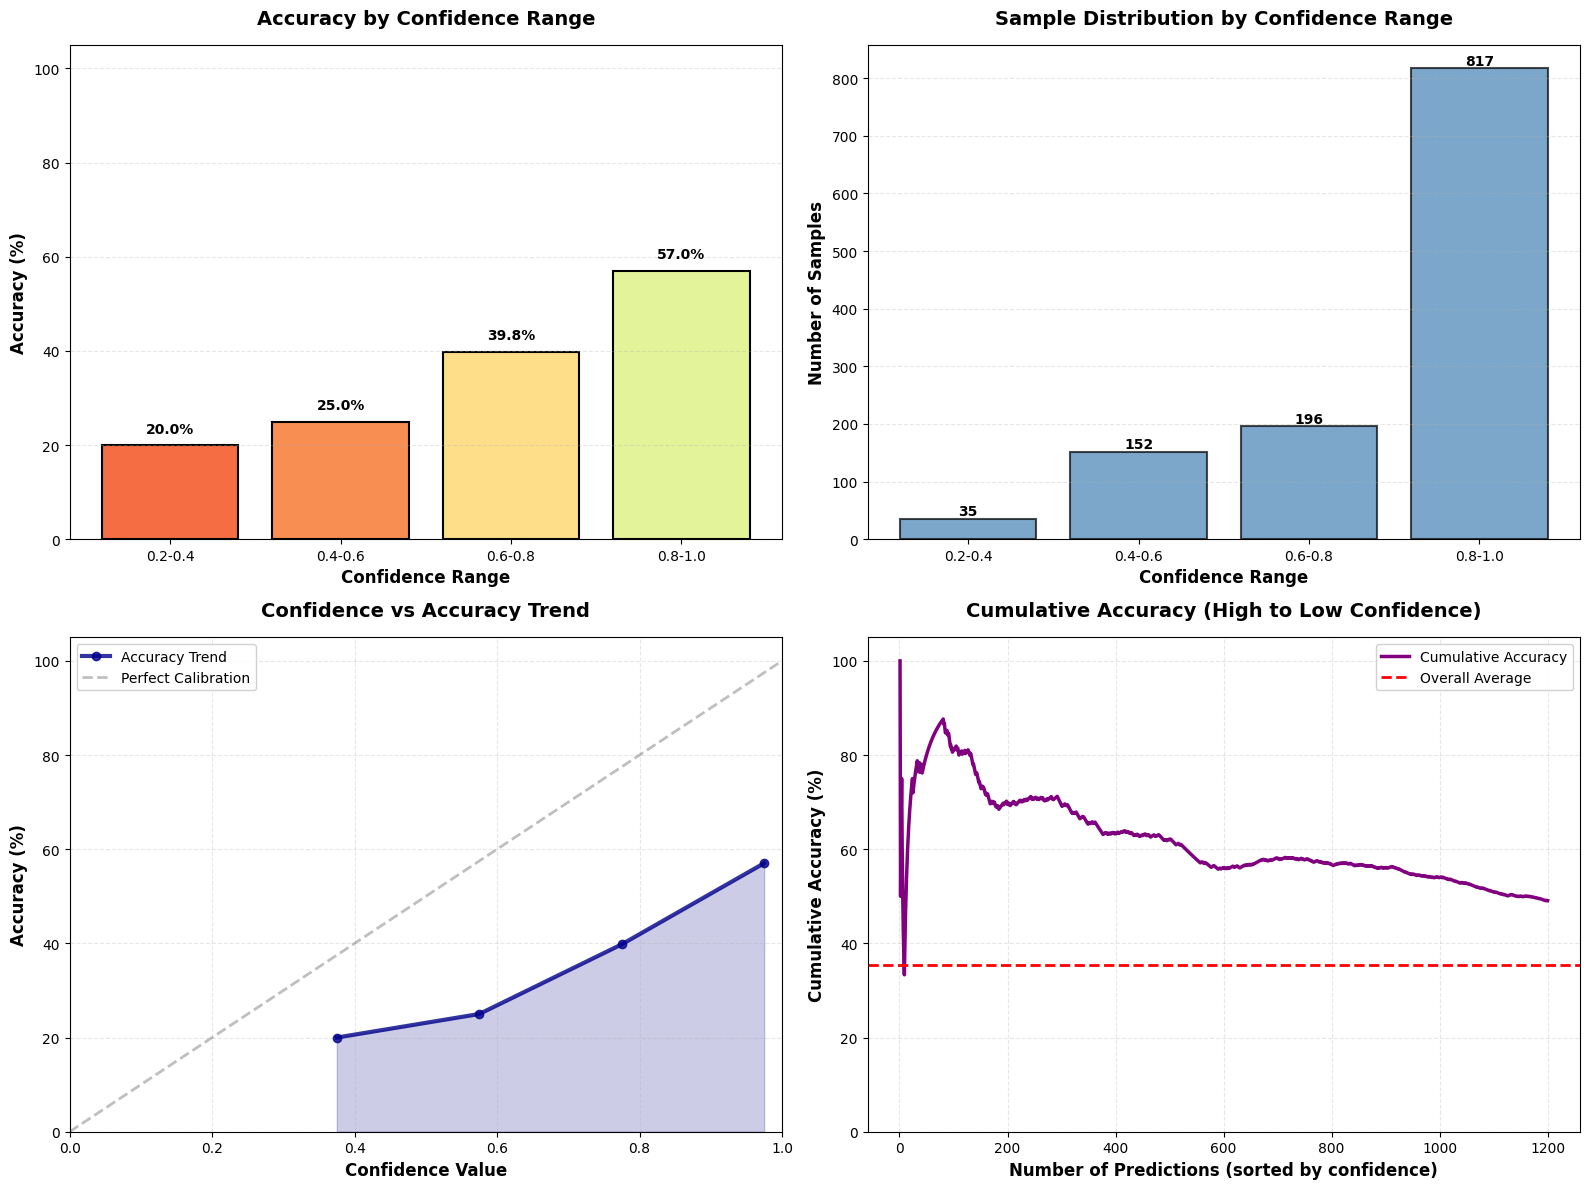

In [9]:
# Generate accuracy vs confidence visualizations
confidence_stats = plot_accuracy_vs_confidence(
    predictions_df=predictions_df,
    output_dir="../results"
)

In [10]:
# Display confidence statistics
print("\n" + "=" * 70)
print("CONFIDENCE STATISTICS SUMMARY")
print("=" * 70)
print(f"Overall Accuracy: {confidence_stats['overall_accuracy']:.2%}")
print(f"High Confidence (≥0.8) Accuracy: {confidence_stats['high_confidence_accuracy']:.2%}")
print(f"Low Confidence (<0.6) Accuracy: {confidence_stats['low_confidence_accuracy']:.2%}")

# Show confidence value distribution
print("\n" + "=" * 70)
print("CONFIDENCE VALUE DISTRIBUTION")
print("=" * 70)
print(predictions_df['confidence'].describe())


CONFIDENCE STATISTICS SUMMARY
Overall Accuracy: 49.08%
High Confidence (≥0.8) Accuracy: 53.70%
Low Confidence (<0.6) Accuracy: 20.00%

CONFIDENCE VALUE DISTRIBUTION
count    1200.000000
mean        0.899167
std         0.164789
min         0.400000
25%         0.800000
50%         1.000000
75%         1.000000
max         1.000000
Name: confidence, dtype: float64
